# Data Cleaning Notebook

## Objectives

* Evaluate missing data
* Clean data

## Inputs

* outputs/datasets/collection/HousePricesRecords.csv

## Outputs

* Generate cleaned Train and Test sets, both saved under outputs/datasets/cleaned

## Additional Comments

* Will add any if needed


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/milestone-project-heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/milestone-project-heritage-housing-issues'

---

# Load Collected data

In [4]:
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/HousePricesRecords.csv")
df.head()

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0       856     854.0           3.0           No         706          GLQ   
1      1262       0.0           3.0           Gd         978          ALQ   
2       920     866.0           3.0           Mn         486          GLQ   
3       961       NaN           NaN           No         216          ALQ   
4      1145       NaN           4.0           Av         655          GLQ   

   BsmtUnfSF  EnclosedPorch  GarageArea GarageFinish  ...  LotFrontage  \
0        150            0.0         548          RFn  ...         65.0   
1        284            NaN         460          RFn  ...         80.0   
2        434            0.0         608          RFn  ...         68.0   
3        540            NaN         642          Unf  ...         60.0   
4        490            0.0         836          RFn  ...         84.0   

   MasVnrArea OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  WoodDeckSF  \
0       196.0          61            5            7          856         0.0   
1         0.0           0            8            6         1262         NaN   
2       162.0          42            5            7          920         NaN   
3         0.0          35            5            7          756         NaN   
4       350.0          84            5            8         1145         NaN   

   YearBuilt  YearRemodAdd  SalePrice  
0       2003          2003     208500  
1       1976          1976     181500  
2       2001          2002     223500  
3       1915          1970     140000  
4       2000          2000     250000  

[5 rows x 24 columns]

---

# Data Exploration

In this Data cleaning we are interested in chekcing the distubution and shape of the variables with missing data

In [5]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

In [6]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

# Correlation and PPS Analysis

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

%matplotlib inline

def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Calculate Correlations and Power Predicitive Score

In [8]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702


Heatmaps



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



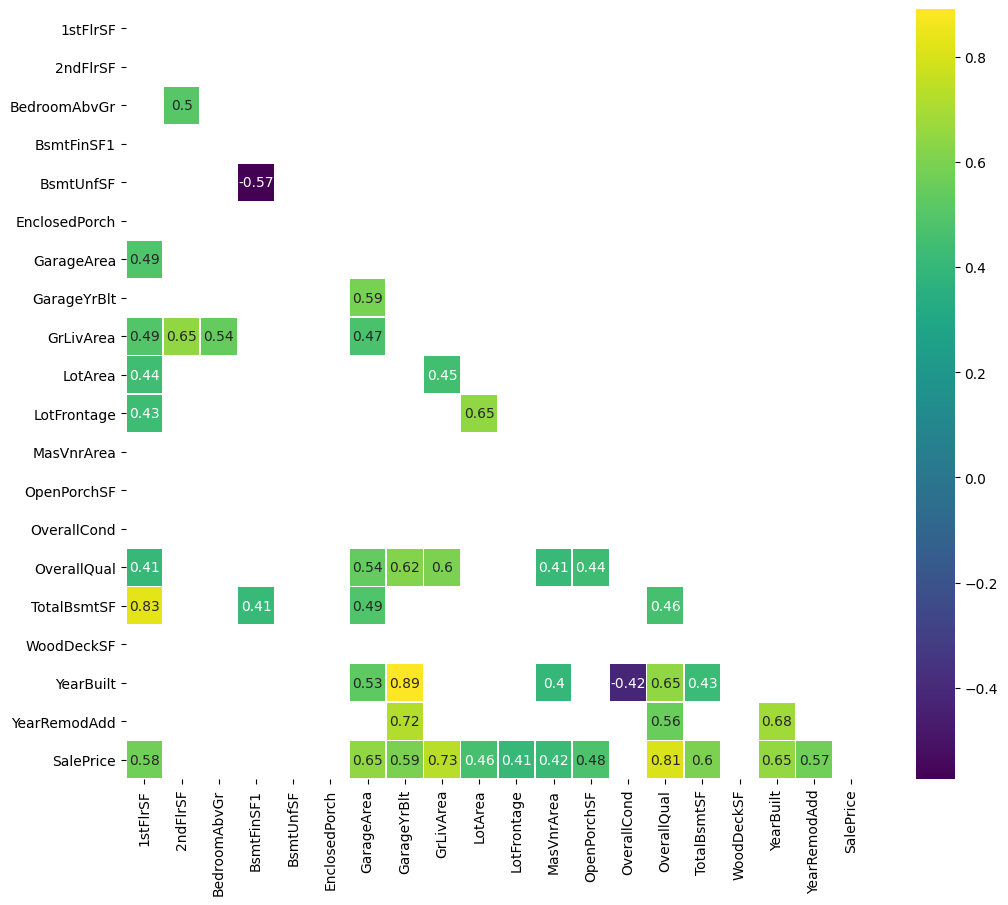



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



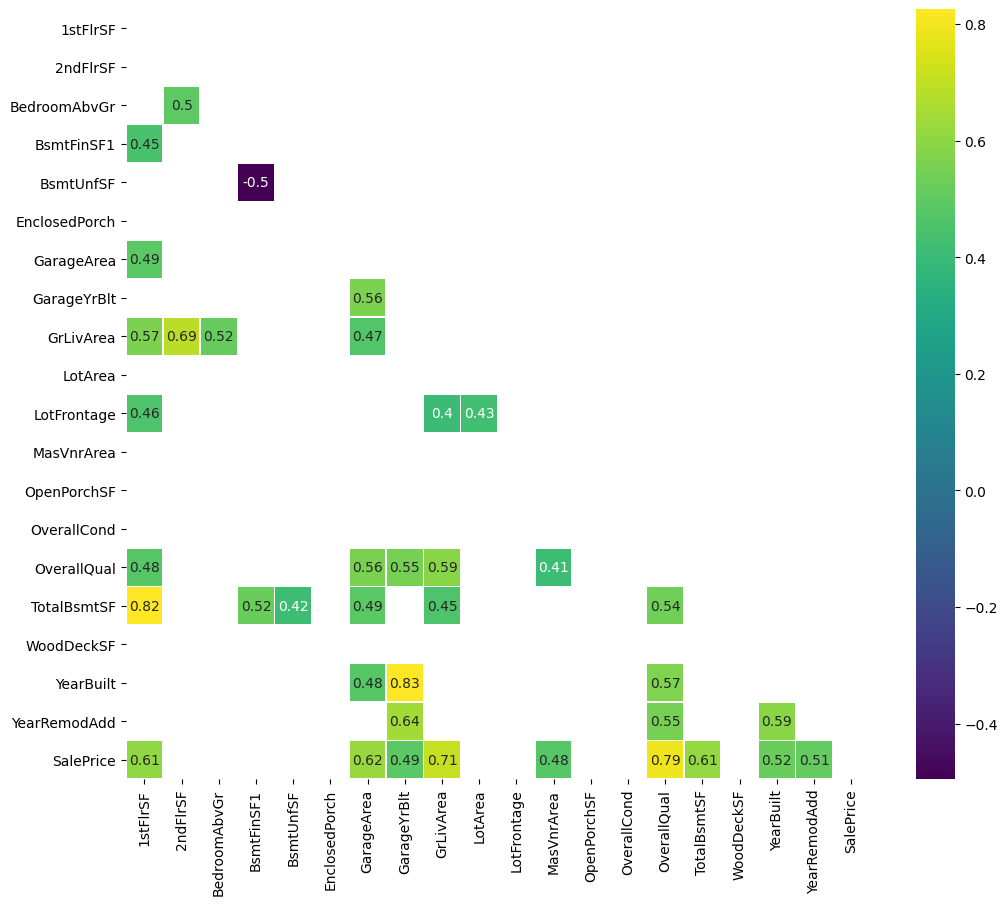



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



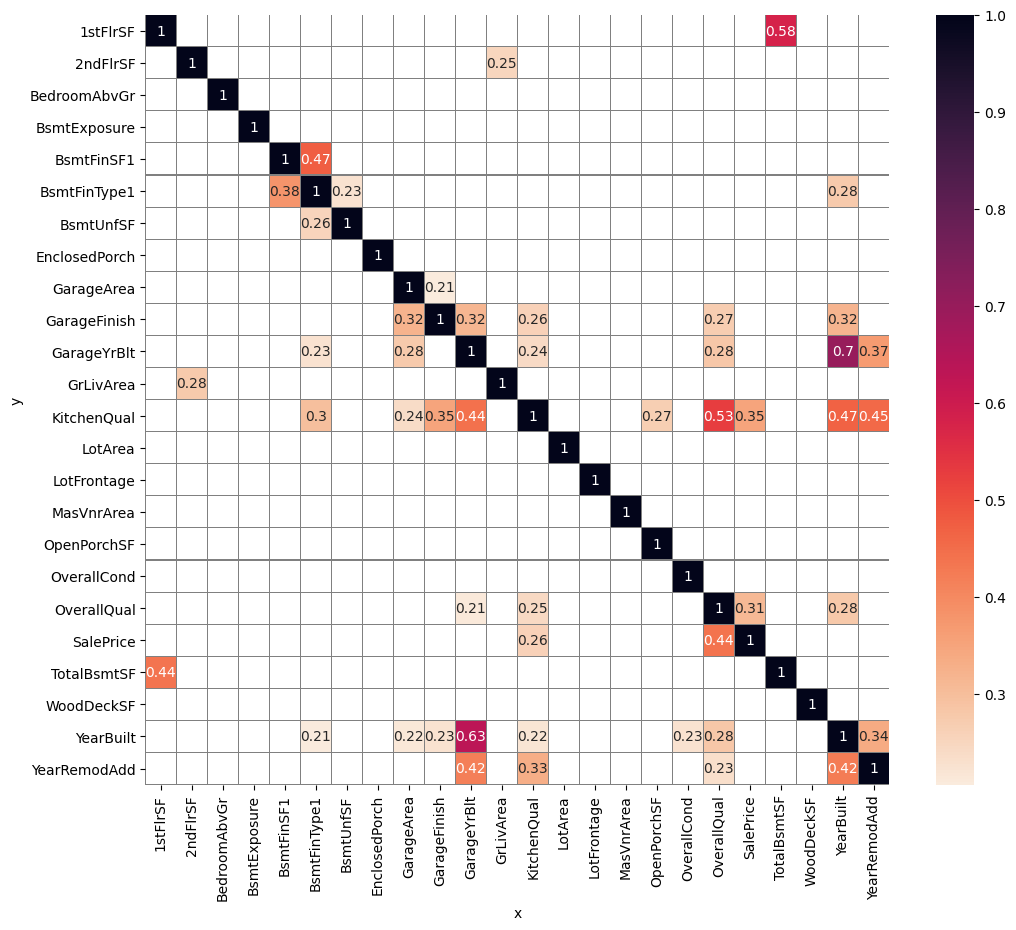

In [9]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

---

# Data Cleaing

## Assessing Missing data levels

* Custom function to display missing data levels in a DataFrame, it shows the absolute levels, relative levels and data type.

In [10]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

Check missing data levels

In [11]:
EvaluateMissingData(df)

RowsWithMissingData  PercentageOfDataset DataType
EnclosedPorch                 1324                90.68  float64
WoodDeckSF                    1305                89.38  float64
LotFrontage                    259                17.74  float64
GarageFinish                   162                11.10   object
BsmtFinType1                   114                 7.81   object
BedroomAbvGr                    99                 6.78  float64
2ndFlrSF                        86                 5.89  float64
GarageYrBlt                     81                 5.55  float64
MasVnrArea                       8                 0.55  float64

From the table above we are able to see the percentage of missing data. We will use this to help make our decision on data cleaning in the section below.

---

## Split Train and Test Set

In [12]:
from sklearn.model_selection import train_test_split

TrainSet, TestSet, _, __ = train_test_split (df, df['SalePrice'], test_size=0.2, random_state=0)
print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

Uncleaned_TrainSet = TrainSet

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


In [13]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

There are 9 variables with missing data 



RowsWithMissingData  PercentageOfDataset DataType
EnclosedPorch                 1056                90.41  float64
WoodDeckSF                    1034                88.53  float64
LotFrontage                    212                18.15  float64
GarageFinish                   131                11.22   object
BsmtFinType1                    89                 7.62   object
BedroomAbvGr                    80                 6.85  float64
2ndFlrSF                        60                 5.14  float64
GarageYrBlt                     58                 4.97  float64
MasVnrArea                       6                 0.51  float64

## Dealing with Missing Data

### Arbitrary Number

From looking at the Profile report on the missing data. I have reviewed and selected: LotFrontage, GarageYrBlt as appropriate varaibles for the Mean imputer to replace their missing data. This is becuase their isn't one value with a frequency that is significat greater than the other values. However if we use the mean imputer we would be adding real numbers to an integer list. So i will calculate the mean value for these varaiables and then round the number to 0 decimal places and use that number for the Arbitrary Number impuation.  

#### LotFrontage

In [14]:
variable_arbitrary_imputer_lot = ['LotFrontage']

print(f"{len(variable_arbitrary_imputer_lot)} variables to use Arbitrary Number on \n{variable_arbitrary_imputer_lot}")

1 variables to use Arbitrary Number on 
 ['LotFrontage']


In [15]:
mean_lot = int(df[variable_arbitrary_imputer_lot].mean().round())
mean_lot

70

In [16]:
from feature_engine.imputation import ArbitraryNumberImputer

imputer_arbitrary_lot = ArbitraryNumberImputer(arbitrary_number=mean_lot, variables=variable_arbitrary_imputer_lot)
imputer_arbitrary_lot.fit(TrainSet)
df_method1 = imputer_arbitrary_lot.transform(TrainSet)

In [17]:
EvaluateMissingData(df_method1)

RowsWithMissingData  PercentageOfDataset DataType
EnclosedPorch                 1056                90.41  float64
WoodDeckSF                    1034                88.53  float64
GarageFinish                   131                11.22   object
BsmtFinType1                    89                 7.62   object
BedroomAbvGr                    80                 6.85  float64
2ndFlrSF                        60                 5.14  float64
GarageYrBlt                     58                 4.97  float64
MasVnrArea                       6                 0.51  float64

In [18]:
profile = ProfileReport(df=df_method1[variable_arbitrary_imputer_lot], minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
from feature_engine.imputation import ArbitraryNumberImputer

imputer_arbitrary_lot = ArbitraryNumberImputer(arbitrary_number=mean_lot, variables=variable_arbitrary_imputer_lot)
imputer_arbitrary_lot.fit(TrainSet)
imputer_arbitrary_lot.transform(TrainSet)

TrainSet, TestSet = imputer_arbitrary_lot.transform(TrainSet), imputer_arbitrary_lot.transform(TestSet)

#### GarageYrBlt

In [20]:
variable_arbitrary_imputer_gar = ['GarageYrBlt']

print(f"{len(variable_arbitrary_imputer_gar)} variables to use Arbitrary Number on \n{variable_arbitrary_imputer_gar}")

1 variables to use Arbitrary Number on 
 ['GarageYrBlt']


In [21]:
mean_gar = int(df[variable_arbitrary_imputer_gar].mean().round())
mean_gar

1979

In [22]:
from feature_engine.imputation import ArbitraryNumberImputer

imputer_arbitrary_gar = ArbitraryNumberImputer(arbitrary_number=mean_gar, variables=variable_arbitrary_imputer_gar)
imputer_arbitrary_gar.fit(TrainSet)
df_method2 = imputer_arbitrary_gar.transform(TrainSet)

In [23]:
EvaluateMissingData(df_method2)

RowsWithMissingData  PercentageOfDataset DataType
EnclosedPorch                 1056                90.41  float64
WoodDeckSF                    1034                88.53  float64
GarageFinish                   131                11.22   object
BsmtFinType1                    89                 7.62   object
BedroomAbvGr                    80                 6.85  float64
2ndFlrSF                        60                 5.14  float64
MasVnrArea                       6                 0.51  float64

In [24]:
profile = ProfileReport(df=df_method2[variable_arbitrary_imputer_gar], minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
from feature_engine.imputation import ArbitraryNumberImputer

imputer_arbitrary_gar = ArbitraryNumberImputer(arbitrary_number=mean_gar, variables=variable_arbitrary_imputer_gar)
imputer_arbitrary_gar.fit(TrainSet)
imputer_arbitrary_gar.transform(TrainSet)

TrainSet, TestSet = imputer_arbitrary_gar.transform(TrainSet), imputer_arbitrary_gar.transform(TestSet)

### Median Imputer

From looking at the Profile report on the missing data. I have revied and selected: BedroomAbvGr, 2ndFlrSF, MasVnrArea as appropriate varaiables for the Median imputer to replace their missing data. For 2ndFlrSF and MasVnrArea this is bacuse they each have one value with over 50% frequency and the second most common value had a frequency of less than 1%. For BedroomAbvGr the most common frequncy was at 51.3% but the second most frequet was 22.8%. however i decided for the median method over the mean method becuase this variable is for number of rooms so having a decimal of rooms wouldn't make much sense and 3 rooms os clearly the most common.

In [26]:
variables_median_imputer = ['BedroomAbvGr', '2ndFlrSF', 'MasVnrArea']

print(f"{len(variables_median_imputer)} variables to use Median Imputer on \n{variables_median_imputer}")

3 variables to use Median Imputer on 
 ['BedroomAbvGr', '2ndFlrSF', 'MasVnrArea']


In [27]:
from feature_engine.imputation import MeanMedianImputer

imputer_median = MeanMedianImputer(imputation_method='median', variables=variables_median_imputer)
imputer_median.fit(TrainSet)
df_method3 = imputer_median.transform(TrainSet)

In [28]:
EvaluateMissingData(df_method3)

RowsWithMissingData  PercentageOfDataset DataType
EnclosedPorch                 1056                90.41  float64
WoodDeckSF                    1034                88.53  float64
GarageFinish                   131                11.22   object
BsmtFinType1                    89                 7.62   object

In [29]:
profile = ProfileReport(df=df_method3[variables_median_imputer], minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
from feature_engine.imputation import MeanMedianImputer

imputer_median = MeanMedianImputer(imputation_method='median', variables=variables_median_imputer)
imputer_median.fit(TrainSet)

TrainSet, TestSet = imputer_median.transform(TrainSet), imputer_median.transform(TestSet)

### Categorical Imputer - Replace with most frequent

From looking at the Profile report on the missing data. I have revied and selected: GarageFinish as the variable to use this on. This is becuase the leading catagory has a 12.3% lead on the previous most common frequency. 

In [31]:
variables_categorical_imputer_frequent = ['GarageFinish']

print(f"{len(variables_categorical_imputer_frequent)} variables to use Categorical Imputer and replace with the most frequent on \n{variables_categorical_imputer_frequent}")

1 variables to use Categorical Imputer and replace with the most frequent on 
['GarageFinish']


In [32]:
from feature_engine.imputation import CategoricalImputer
from sklearn.pipeline import Pipeline

pipeline_frequent = Pipeline([
      ( 'categorical_imputer', CategoricalImputer(imputation_method='frequent', variables=variables_categorical_imputer_frequent) )
])

In [33]:
df_method4 = pipeline_frequent.fit_transform(TrainSet)

In [34]:
EvaluateMissingData(df_method4)

RowsWithMissingData  PercentageOfDataset DataType
EnclosedPorch                 1056                90.41  float64
WoodDeckSF                    1034                88.53  float64
BsmtFinType1                    89                 7.62   object

In [35]:
profile = ProfileReport(df=df_method4[variables_categorical_imputer_frequent], minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [36]:
pipeline_frequent.fit(TrainSet)
TrainSet, TestSet = pipeline_frequent.transform(TrainSet), pipeline_frequent.transform(TestSet)

### Categorical Imputer - Replace with 'Missing'

From looking at the Profile report on the missing data. I have revied and selected: BsmtFinType1. This is because there is less than 1% difference in the frequency between the two most frequnt options. 

In [37]:
variables_categorical_imputer_missing = ['BsmtFinType1']

print(f"{len(variables_categorical_imputer_missing)} variables to use Categorical Imputer and replace with the missing on \n{variables_categorical_imputer_missing}")

1 variables to use Categorical Imputer and replace with the missing on 
['BsmtFinType1']


In [38]:
from feature_engine.imputation import CategoricalImputer
from sklearn.pipeline import Pipeline

pipeline_missing = Pipeline([
      ('categorical_imputer', CategoricalImputer(imputation_method='missing',
                                                  fill_value='Missing',
                                                  variables=variables_categorical_imputer_missing))
])

In [39]:
df_method5 = pipeline_missing.fit_transform(TrainSet)

In [40]:
EvaluateMissingData(df_method5)

RowsWithMissingData  PercentageOfDataset DataType
EnclosedPorch                 1056                90.41  float64
WoodDeckSF                    1034                88.53  float64

In [41]:
profile = ProfileReport(df=df_method5[variables_categorical_imputer_missing], minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [42]:
pipeline_missing.fit(TrainSet)
TrainSet, TestSet = pipeline_missing.transform(TrainSet), pipeline_missing.transform(TestSet)

### Drop Variables

From the Assessing Missing data levels section we found that the variables EnclosedPorch and WoodDeckSF both had a percentage of missing data of over 80%. Becuase of this we can drop these two variables. 

In [43]:
variables_dropped = ['EnclosedPorch', 'WoodDeckSF']

print(f"{len(variables_dropped)} variables to drop \n{variables_dropped}")

2 variables to drop 
['EnclosedPorch', 'WoodDeckSF']


In [44]:
from feature_engine.selection import DropFeatures
imputer = DropFeatures(features_to_drop=variables_dropped)
imputer.fit(TrainSet)
df_method6 = imputer.transform(TrainSet)

In [45]:
from feature_engine.selection import DropFeatures
imputer = DropFeatures(features_to_drop=variables_dropped)
imputer.fit(TrainSet)

TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

In [46]:
EvaluateMissingData(TrainSet)

Empty DataFrame
Columns: [RowsWithMissingData, PercentageOfDataset, DataType]
Index: []

---

# Before and after Data Cleaing comparisons

In [47]:
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):

  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over variables, 
    # first on variables that you applied the method
    # if the variable is a numerical plot, a histogram if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['LotFrontage', 'GarageFinish', 'BsmtFinType1', 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea'] 




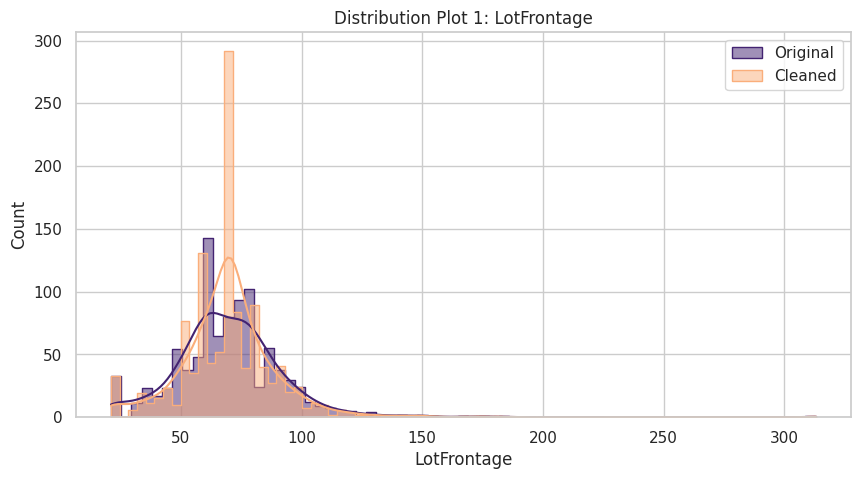

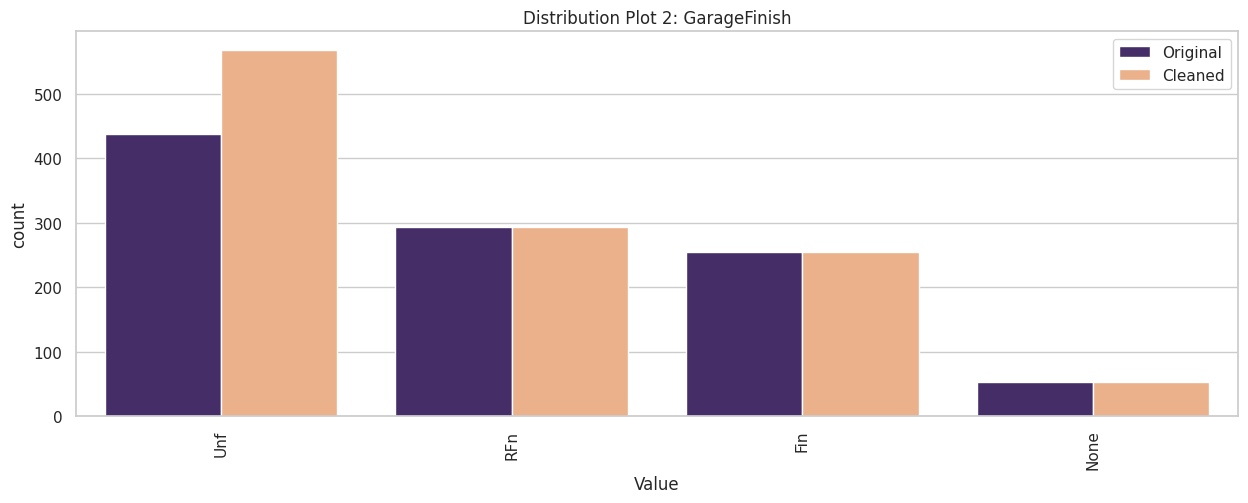

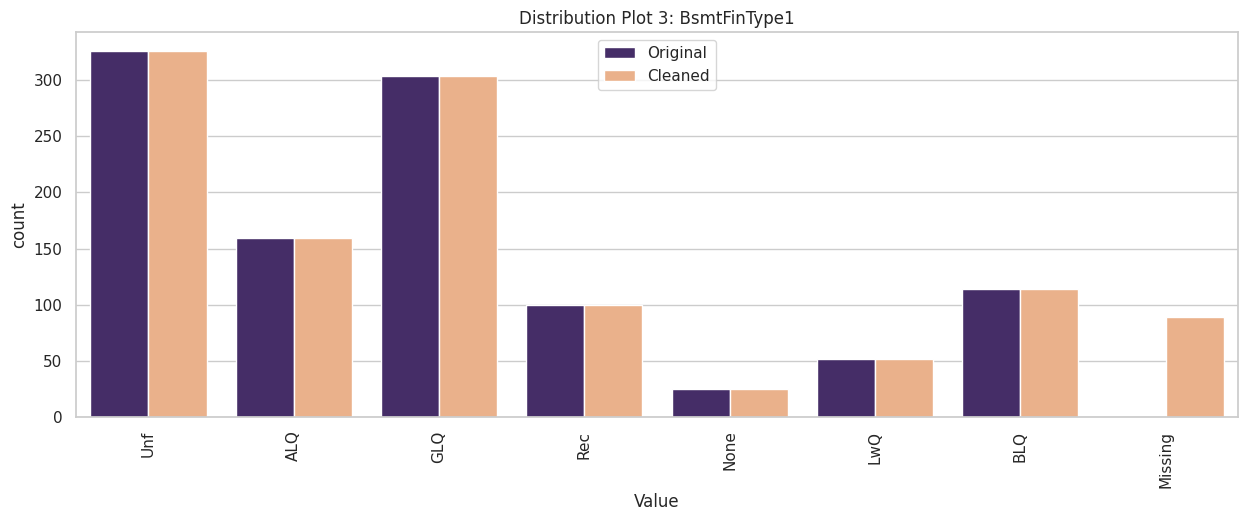

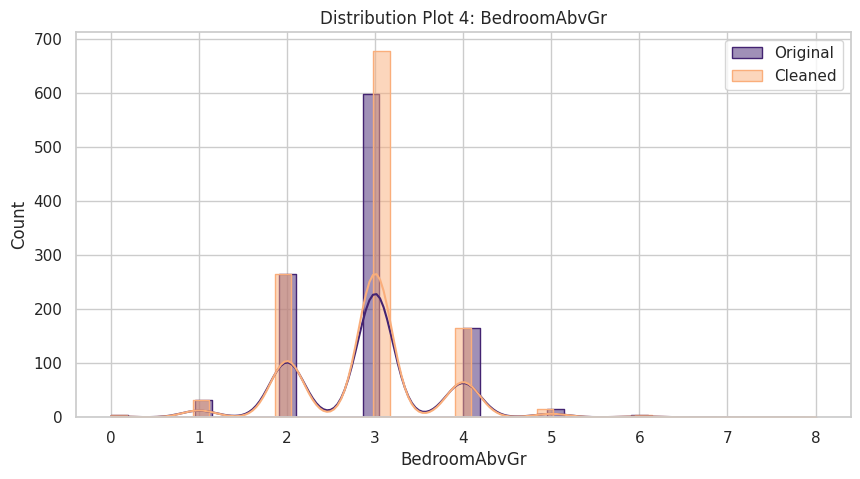

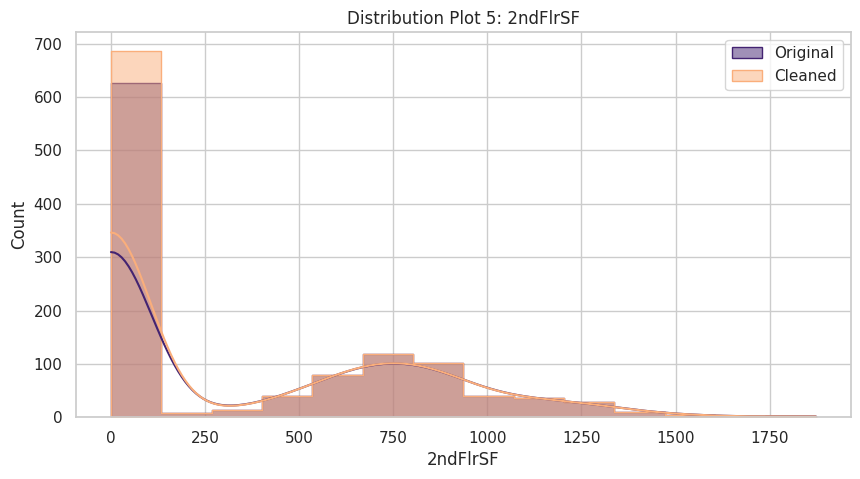

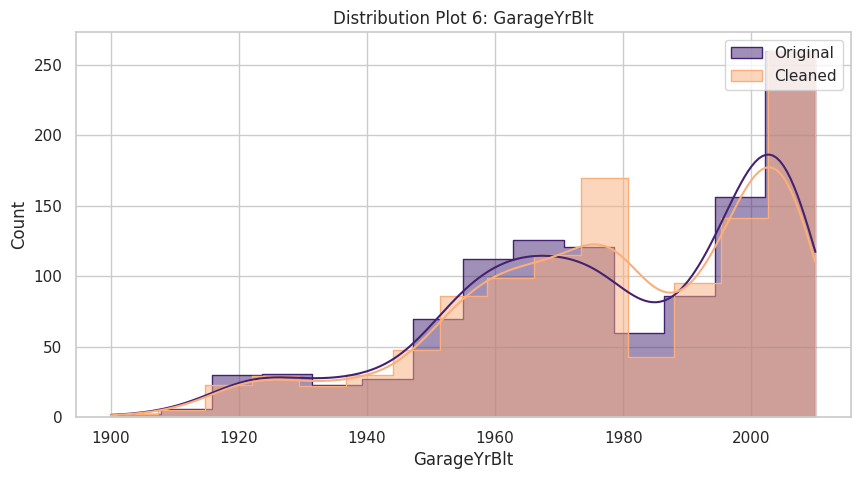

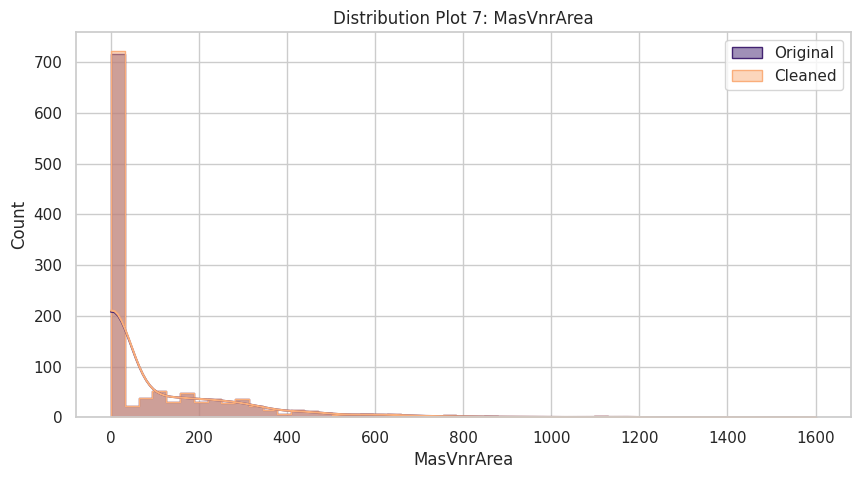

In [49]:
DataCleaningEffect(df_original=Uncleaned_TrainSet ,df_cleaned=TrainSet,variables_applied_with_method=['LotFrontage', 'GarageFinish', 'BsmtFinType1', 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea'])

---

# Push files to Repo

In [ ]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
  print(e)


## Train Set

In [ ]:
TrainSet.to_c